In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Concatenate, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import matplotlib.pyplot as plt
import re
import string
import random
import os
import io

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
# Load data
with open('Quran-EN', 'r', encoding='utf-8') as file:
    english_text = file.read().splitlines()
with open('Quran-UR', 'r', encoding='utf-8') as file:
    urdu_text = file.read().splitlines()

print(f"Total English lines: {len(english_text)}")
print(f"Total Urdu lines: {len(urdu_text)}")

Total English lines: 6414
Total Urdu lines: 6414


In [4]:
# Sample and print some data
for i in range(3):
    idx = random.randint(0, len(english_text)-1)
    print(f"English: {english_text[idx]}")
    print(f"Urdu: {urdu_text[idx]}")
    print()

English: Assuredly this is the absolute Truth of Certitude .
Urdu: بیشک یہی قطعی طور پر حق الیقین ہے ۔

English: O Believers ! When death approaches anyone of you , then at the time of making a bequest there should be two men of probity from amongst you ( for ) taking testimony or ( any ) two men from among others if you are travelling in the land . If ( in the meanwhile ) the agony of death overtakes you , detain both of them after Prayer . If you suspect ( them ) they shall both swear by Allah : We shall not sell it for any price , even though one is a ( very close ) relative , nor shall we conceal the testimony ( ordained ) by Allah . ( If we hide it , ) we shall be among sinners there and then .
Urdu: اے ایمان والو ! جب تم میں سے کسی کی موت آئے تو وصیت کرتے وقت تمہارے درمیان گواہی کے لئے تم میں سے دو عادل شخص ہوں یا تمہارے غیروں میں سے کوئی دوسرے دو شخص ہوں اگر تم ملک میں سفر کر رہے ہو پھر اسی حال میں تمہیں موت کی مصیبت آپہنچے تو تم ان دونوں کو نماز کے بعد روک لو ، اگر تمہیں ان پر 

In [5]:
# Preprocessing functions
ENGLISH_SPECIAL_TERMS = ['Allah', 'Messenger', 'Lord', 'Quran']
punc = set(string.punctuation)

def preprocess_eng_sentence(sent):
    """Preprocess English sentences while preserving sacred terms"""
    sent = sent.lower()
    sent = re.sub("'", '', sent)  # Remove apostrophes
    sent = ''.join(ch for ch in sent if ch not in punc)  # Remove punctuation
    sent = re.sub(r'[0-9]', '', sent)  # Remove numbers
    sent = ' '.join(sent.split())  # Handles multiple spaces

    # Restore capitalization for sacred terms
    for term in ENGLISH_SPECIAL_TERMS:
        sent = sent.replace(term.lower(), term)
    return f'<start> {sent} <end>'

urdu_diacritics = ['ِ', 'ٰ', 'ُ', 'ٍ', 'ً', 'َ', 'ْ', 'ّ', 'ٓ']
urdu_digits = ['۶', '۴', '۵', '۸', '۲', '۰', '۷', '۹', '۳', '۱']
URDU_PUNCTUATIONS = ['؛', '۔', '٫', '٪', '+', '=', '@', '#', '!', '؟', '،',
                    '(', ')', '{', '}', '_', '—', '-', '«', '»', '﴾', '﴿', ''', ''']

to_remove = set(URDU_PUNCTUATIONS + urdu_diacritics + urdu_digits + ["'"])

def preprocess_ur_sentence(sent):
    """Preprocess Urdu sentences by removing punctuation, diacritics, and digits"""
    sent = ''.join(ch for ch in sent if ch not in to_remove and not ch.isdigit())
    sent = ' '.join(sent.split())
    return f'<start> {sent} <end>'

In [6]:
# Apply preprocessing
english_processed = [preprocess_eng_sentence(line) for line in english_text]
urdu_processed = [preprocess_ur_sentence(line) for line in urdu_text]

print("After preprocessing:")
for i in range(2):
    idx = random.randint(0, len(english_processed)-1)
    print(f"English: {english_processed[idx]}")
    print(f"Urdu: {urdu_processed[idx]}")
    print()

After preprocessing:
English: <start> no doubt he thought he would never return to his Lord for reckoning <end>
Urdu: <start> بیشک اس نے یہ گمان کر لیا تھا کہ وہ حساب کے لئے اللہ کے پاس ہرگز لوٹ کر نہ جائے گا <end>

English: <start> but that by your Lords mercy we have kept it intact this is indeed his mighty favour to you and through you to your umma community <end>
Urdu: <start> مگر یہ کہ آپ کے رب کی رحمت سے ہم نے اسے قائم رکھا ہے بیشک یہ آپ پر اور آپ کے وسیلہ سے آپ کی امت پر اس کا بہت بڑا فضل ہے <end>



In [7]:
# Split data into train, validation, and test sets (80%, 10%, 10%)
indices = list(range(len(english_processed)))
random.shuffle(indices)

train_size = int(0.8 * len(indices))
val_size = int(0.1 * len(indices))

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

In [8]:
# Create dataset splits
train_en = [english_processed[i] for i in train_indices]
train_ur = [urdu_processed[i] for i in train_indices]
val_en = [english_processed[i] for i in val_indices]
val_ur = [urdu_processed[i] for i in val_indices]
test_en = [english_processed[i] for i in test_indices]
test_ur = [urdu_processed[i] for i in test_indices]

print(f"Train set size: {len(train_en)}")
print(f"Validation set size: {len(val_en)}")
print(f"Test set size: {len(test_en)}")

Train set size: 5131
Validation set size: 641
Test set size: 642


In [9]:
# Create tokenizers
# English tokenizer
en_tokenizer = Tokenizer(filters='')
en_tokenizer.fit_on_texts(train_en)
en_vocab_size = len(en_tokenizer.word_index) + 1  # +1 for padding token
print(f"English vocabulary size: {en_vocab_size}")

# Urdu tokenizer
ur_tokenizer = Tokenizer(filters='')
ur_tokenizer.fit_on_texts(train_ur)
ur_vocab_size = len(ur_tokenizer.word_index) + 1  # +1 for padding token
print(f"Urdu vocabulary size: {ur_vocab_size}")

English vocabulary size: 7443
Urdu vocabulary size: 6684


In [10]:
# Convert text to sequences
train_en_seq = en_tokenizer.texts_to_sequences(train_en)
train_ur_seq = ur_tokenizer.texts_to_sequences(train_ur)
val_en_seq = en_tokenizer.texts_to_sequences(val_en)
val_ur_seq = ur_tokenizer.texts_to_sequences(val_ur)
test_en_seq = en_tokenizer.texts_to_sequences(test_en)
test_ur_seq = ur_tokenizer.texts_to_sequences(test_ur)

In [11]:
# Find maximum sequence lengths
max_en_len = max(len(seq) for seq in train_en_seq)
max_ur_len = max(len(seq) for seq in train_ur_seq)
print(f"Maximum English sequence length: {max_en_len}")
print(f"Maximum Urdu sequence length: {max_ur_len}")

Maximum English sequence length: 202
Maximum Urdu sequence length: 223


In [12]:
# Pad sequences
train_en_pad = pad_sequences(train_en_seq, maxlen=max_en_len, padding='post')
train_ur_pad = pad_sequences(train_ur_seq, maxlen=max_ur_len, padding='post')
val_en_pad = pad_sequences(val_en_seq, maxlen=max_en_len, padding='post')
val_ur_pad = pad_sequences(val_ur_seq, maxlen=max_ur_len, padding='post')
test_en_pad = pad_sequences(test_en_seq, maxlen=max_en_len, padding='post')
test_ur_pad = pad_sequences(test_ur_seq, maxlen=max_ur_len, padding='post')

In [13]:
# For teacher-forcing during training, we need to prepare decoder inputs and outputs

In [14]:
# Decoder inputs: remove the <end> token (last token)
# Decoder outputs: remove the <start> token (first token)
train_ur_input = train_ur_pad[:, :-1]
train_ur_output = train_ur_pad[:, 1:]
val_ur_input = val_ur_pad[:, :-1]
val_ur_output = val_ur_pad[:, 1:]

In [15]:
# Verify the shapes
print(f"Training encoder input shape: {train_en_pad.shape}")
print(f"Training decoder input shape: {train_ur_input.shape}")
print(f"Training decoder output shape: {train_ur_output.shape}")

Training encoder input shape: (5131, 202)
Training decoder input shape: (5131, 222)
Training decoder output shape: (5131, 222)


In [20]:
# ====== BUILDING THE TRANSLATION MODEL ======

# Define embedding dimensions and hidden units
EMBEDDING_DIM = 256
LSTM_UNITS = 512
BATCH_SIZE = 32
EPOCHS = 8  # Training for at least 10 epochs as requested

In [21]:
# ====== Model 1: Seq2Seq with Attention ======

# Encoder
encoder_inputs = Input(shape=(max_en_len,))
enc_emb = Embedding(en_vocab_size, EMBEDDING_DIM)(encoder_inputs)
encoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(ur_vocab_size, EMBEDDING_DIM)
dec_emb = dec_emb_layer(decoder_inputs)

# Using LSTM with return_sequences=True to get output for each time step
decoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Attention mechanism
# Using Bahdanau-style attention (additive attention)
attention = tf.keras.layers.Attention()
context_vector = attention([decoder_outputs, encoder_outputs])

# Concatenate the context vector with decoder outputs
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context_vector])

# Apply a dense layer to generate outputs
decoder_dense = Dense(ur_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 202)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 202, 256)  │  1,905,408 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 256) │  1,711,104 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 202,      │  1,574,912 │ embedding_2[0][0] │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_3[0][0… │
│                     │ 512), (None,      │            │ lstm_2[0][1],     │
│                     │ 512), (None,      │            │ lstm_2[0][2]      │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None,      │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │ 1024)             │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │  6,851,100 │ concatenate_1[0]… │
│                     │ 6684)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,617,436 (51.95 MB)

 Trainable params: 13,617,436 (51.95 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
# Create a folder for model checkpoints
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

# Callbacks
checkpoint = ModelCheckpoint('model_checkpoints/best_model.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)

In [23]:
# Train the model
history = model.fit(
    [train_en_pad, train_ur_input],
    train_ur_output,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([val_en_pad, val_ur_input], val_ur_output),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8037 - loss: 1.8688
Epoch 1: val_loss improved from inf to 0.94354, saving model to model_checkpoints/best_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.8039 - loss: 1.8648 - val_accuracy: 0.8535 - val_loss: 0.9435
Epoch 2/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8441 - loss: 0.9892
Epoch 2: val_loss improved from 0.94354 to 0.82653, saving model to model_checkpoints/best_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.8441 - loss: 0.9889 - val_accuracy: 0.8623 - val_loss: 0.8265
Epoch 3/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8526 - loss: 0.8773
Epoch 3: val_loss improved from 0.82653 to 0.77650, saving model to model_checkpoints/best_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.8526 - loss: 0.8771 - val_accuracy: 0.8672 - val_loss: 0.7765
Epoch 4/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8579 - 

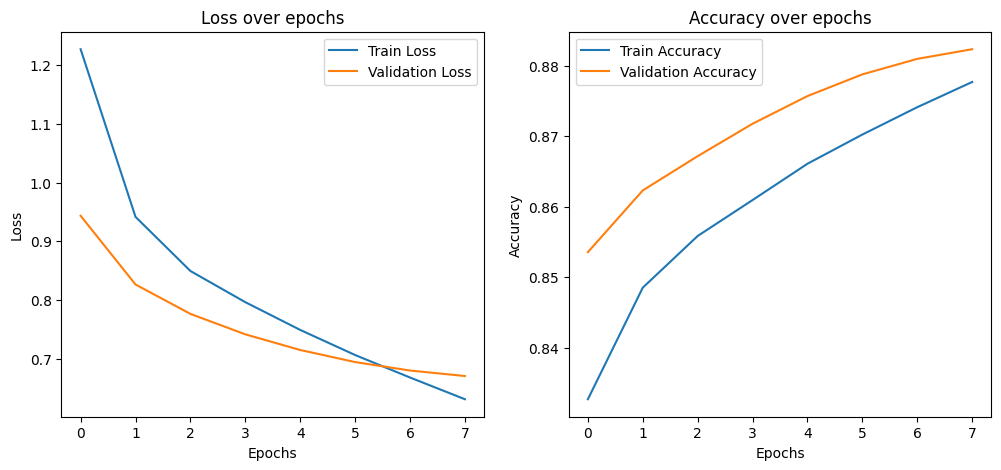

In [24]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
# ====== INFERENCE MODEL ======
# For inference, we need separate encoder and decoder models

# Create encoder inference model
encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

# Create decoder inference model
decoder_state_input_h = Input(shape=(LSTM_UNITS,))
decoder_state_input_c = Input(shape=(LSTM_UNITS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_state_input = Input(shape=(max_en_len, LSTM_UNITS))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# Attention during inference
context_vector2 = attention([decoder_outputs2, decoder_hidden_state_input])
decoder_combined_context2 = Concatenate(axis=-1)([decoder_outputs2, context_vector2])
decoder_outputs2 = decoder_dense(decoder_combined_context2)

decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [26]:
# ====== TRANSLATION FUNCTION ======
def translate_sentence(input_sentence, encoder_model, decoder_model, en_tokenizer, ur_tokenizer, max_len_target):
    """Translate an English sentence to Urdu"""
    # Preprocess the input sentence
    processed_input = preprocess_eng_sentence(input_sentence)

    # Convert to sequence
    input_seq = en_tokenizer.texts_to_sequences([processed_input])
    input_seq = pad_sequences(input_seq, maxlen=max_en_len, padding='post')

    # Encode the input
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)

    # Start with the <start> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = ur_tokenizer.word_index['<start>']

    # Initialize the output
    decoded_sentence = ''

    # Decode the sentence
    while True:
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs, state_h, state_c]
        )

        # Get the next token with highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Convert the token to word
        sampled_word = None
        for word, index in ur_tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break

        # Stop if we hit the end token or maximum length
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_len_target:
            break

        # Append the word to the output
        if sampled_word is not None and sampled_word != '<start>':
            decoded_sentence += sampled_word + ' '

        # Update the target sequence for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update the states
        state_h, state_c = h, c

    return decoded_sentence.strip()

In [27]:
# ====== EVALUATION FUNCTION ======
def calculate_bleu_scores(references, hypotheses):
    """Calculate BLEU scores for the translations"""
    # Calculate BLEU-1 to BLEU-4
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    print(f"BLEU-1: {bleu_1:.4f}")
    print(f"BLEU-2: {bleu_2:.4f}")
    print(f"BLEU-3: {bleu_3:.4f}")
    print(f"BLEU-4: {bleu_4:.4f}")

    return bleu_1, bleu_2, bleu_3, bleu_4

In [28]:
# ====== EVALUATION ON TEST SET ======
def evaluate_model():
    """Evaluate the model on the test set"""
    references = []
    hypotheses = []

    # Take a subset of test set for evaluation (to save time)
    num_examples = min(100, len(test_en))

    for i in range(num_examples):
        # Get the original English sentence (without preprocessing)
        input_sentence = test_en[i].replace('<start> ', '').replace(' <end>', '')

        # Get the ground truth Urdu sentence
        reference = test_ur[i].replace('<start> ', '').replace(' <end>', '').split()
        references.append([reference])

        # Translate the sentence
        translated = translate_sentence(
            input_sentence,
            encoder_model,
            decoder_model,
            en_tokenizer,
            ur_tokenizer,
            max_ur_len
        )

        # Add the translation to hypotheses
        hypotheses.append(translated.split())

        # Print some examples
        if i < 5:
            print(f"English: {input_sentence}")
            print(f"Reference Urdu: {' '.join(reference)}")
            print(f"Translated Urdu: {translated}")
            print()

    # Calculate BLEU scores
    bleu_scores = calculate_bleu_scores(references, hypotheses)
    return bleu_scores


# ====== ENGLISH TO URDU MODEL EVALUATION ======
print("\n====== ENGLISH TO URDU TRANSLATION ======")
en_to_ur_bleu = evaluate_model()


====== ENGLISH TO URDU TRANSLATION ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━

In [29]:
# ====== URDU TO ENGLISH MODEL ======
# We can also create an Urdu to English model by reversing the source and target

# Create tokenizers for the reversed direction
ur_en_tokenizer = Tokenizer(filters='')
ur_en_tokenizer.fit_on_texts(train_ur)
ur_en_vocab_size = len(ur_en_tokenizer.word_index) + 1

en_ur_tokenizer = Tokenizer(filters='')
en_ur_tokenizer.fit_on_texts(train_en)
en_ur_vocab_size = len(en_ur_tokenizer.word_index) + 1

# Convert text to sequences
train_ur_en_seq = ur_en_tokenizer.texts_to_sequences(train_ur)
train_en_ur_seq = en_ur_tokenizer.texts_to_sequences(train_en)
val_ur_en_seq = ur_en_tokenizer.texts_to_sequences(val_ur)
val_en_ur_seq = en_ur_tokenizer.texts_to_sequences(val_en)
test_ur_en_seq = ur_en_tokenizer.texts_to_sequences(test_ur)
test_en_ur_seq = en_ur_tokenizer.texts_to_sequences(test_en)

# Find maximum sequence lengths
max_ur_en_len = max(len(seq) for seq in train_ur_en_seq)
max_en_ur_len = max(len(seq) for seq in train_en_ur_seq)

# Pad sequences
train_ur_en_pad = pad_sequences(train_ur_en_seq, maxlen=max_ur_en_len, padding='post')
train_en_ur_pad = pad_sequences(train_en_ur_seq, maxlen=max_en_ur_len, padding='post')
val_ur_en_pad = pad_sequences(val_ur_en_seq, maxlen=max_ur_en_len, padding='post')
val_en_ur_pad = pad_sequences(val_en_ur_seq, maxlen=max_en_ur_len, padding='post')
test_ur_en_pad = pad_sequences(test_ur_en_seq, maxlen=max_ur_en_len, padding='post')
test_en_ur_pad = pad_sequences(test_en_ur_seq, maxlen=max_en_ur_len, padding='post')

# Prepare decoder inputs and outputs
train_en_ur_input = train_en_ur_pad[:, :-1]
train_en_ur_output = train_en_ur_pad[:, 1:]
val_en_ur_input = val_en_ur_pad[:, :-1]
val_en_ur_output = val_en_ur_pad[:, 1:]

In [30]:
# ====== BUILDING THE URDU TO ENGLISH MODEL ======

# Encoder
ur_encoder_inputs = Input(shape=(max_ur_en_len,))
ur_enc_emb = Embedding(ur_en_vocab_size, EMBEDDING_DIM)(ur_encoder_inputs)
ur_encoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True)
ur_encoder_outputs, ur_state_h, ur_state_c = ur_encoder_lstm(ur_enc_emb)
ur_encoder_states = [ur_state_h, ur_state_c]

# Decoder
en_decoder_inputs = Input(shape=(None,))
en_dec_emb_layer = Embedding(en_ur_vocab_size, EMBEDDING_DIM)
en_dec_emb = en_dec_emb_layer(en_decoder_inputs)

en_decoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True)
en_decoder_outputs, _, _ = en_decoder_lstm(en_dec_emb, initial_state=ur_encoder_states)

# Attention mechanism
ur_en_attention = tf.keras.layers.Attention()
ur_en_context_vector = ur_en_attention([en_decoder_outputs, ur_encoder_outputs])

# Concatenate the context vector with decoder outputs
en_decoder_combined_context = Concatenate(axis=-1)([en_decoder_outputs, ur_en_context_vector])

# Apply a dense layer to generate outputs
en_decoder_dense = Dense(en_ur_vocab_size, activation='softmax')
en_decoder_outputs = en_decoder_dense(en_decoder_combined_context)

# Final model
ur_en_model = Model([ur_encoder_inputs, en_decoder_inputs], en_decoder_outputs)
ur_en_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(ur_en_model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 223)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 223, 256)  │  1,711,104 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 256) │  1,905,408 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 223,      │  1,574,912 │ embedding_4[0][0] │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_5[0][0… │
│                     │ 512), (None,      │            │ lstm_4[0][1],     │
│                     │ 512), (None,      │            │ lstm_4[0][2]      │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, None, 512) │          0 │ lstm_5[0][0],     │
│ (Attention)         │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, None,      │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │ 1024)             │            │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None,      │  7,629,075 │ concatenate_3[0]… │
│                     │ 7443)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,395,411 (54.91 MB)

 Trainable params: 14,395,411 (54.91 MB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
# Train the Urdu to English model
ur_en_history = ur_en_model.fit(
    [train_ur_en_pad, train_en_ur_input],
    train_en_ur_output,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([val_ur_en_pad, val_en_ur_input], val_en_ur_output),
    callbacks=[
        ModelCheckpoint('model_checkpoints/best_ur_en_model.keras',
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True),

        EarlyStopping(monitor='val_loss',
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)
    ]
)

Epoch 1/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8078 - loss: 1.8438
Epoch 1: val_loss improved from inf to 0.92989, saving model to model_checkpoints/best_ur_en_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.8080 - loss: 1.8398 - val_accuracy: 0.8558 - val_loss: 0.9299
Epoch 2/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8470 - loss: 0.9976
Epoch 2: val_loss improved from 0.92989 to 0.84260, saving model to model_checkpoints/best_ur_en_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 236ms/step - accuracy: 0.8470 - loss: 0.9974 - val_accuracy: 0.8650 - val_loss: 0.8426
Epoch 3/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8574 - loss: 0.8959
Epoch 3: val_loss improved from 0.84260 to 0.78575, saving model to model_checkpoints/best_ur_en_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 42s 240ms/step - accuracy: 0.8574 - loss: 0.8957 - val_accuracy: 0.8720 - val_loss: 0.7858
Epoch 4/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - a

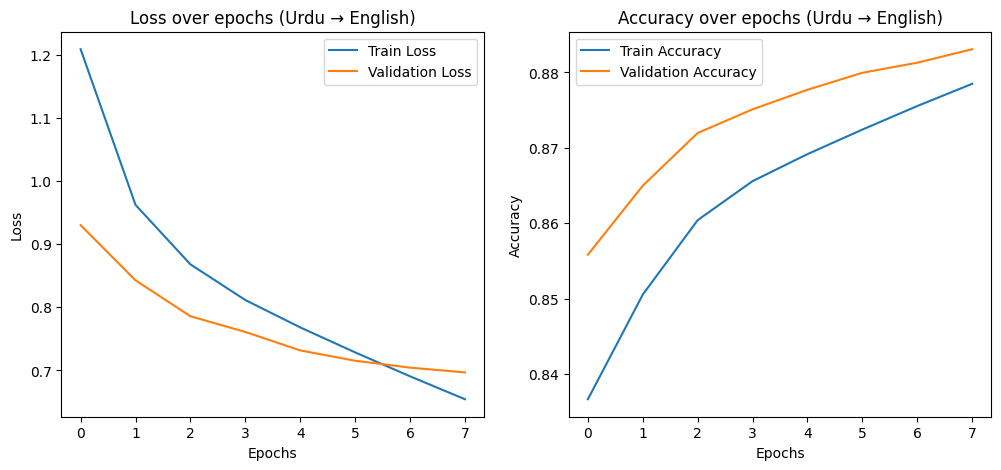

In [32]:
# Plot training history for Urdu to English model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ur_en_history.history['loss'], label='Train Loss')
plt.plot(ur_en_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs (Urdu → English)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ur_en_history.history['accuracy'], label='Train Accuracy')
plt.plot(ur_en_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs (Urdu → English)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
# Create inference models for Urdu to English translation
ur_encoder_model = Model(ur_encoder_inputs, [ur_encoder_outputs] + ur_encoder_states)

en_decoder_state_input_h = Input(shape=(LSTM_UNITS,))
en_decoder_state_input_c = Input(shape=(LSTM_UNITS,))
en_decoder_states_inputs = [en_decoder_state_input_h, en_decoder_state_input_c]
en_decoder_hidden_state_input = Input(shape=(max_ur_en_len, LSTM_UNITS))

en_dec_emb2 = en_dec_emb_layer(en_decoder_inputs)
en_decoder_outputs2, en_state_h2, en_state_c2 = en_decoder_lstm(en_dec_emb2, initial_state=en_decoder_states_inputs)
en_decoder_states2 = [en_state_h2, en_state_c2]

# Attention during inference
en_context_vector2 = ur_en_attention([en_decoder_outputs2, en_decoder_hidden_state_input])
en_decoder_combined_context2 = Concatenate(axis=-1)([en_decoder_outputs2, en_context_vector2])
en_decoder_outputs2 = en_decoder_dense(en_decoder_combined_context2)

en_decoder_model = Model(
    [en_decoder_inputs, en_decoder_hidden_state_input] + en_decoder_states_inputs,
    [en_decoder_outputs2] + en_decoder_states2
)


In [34]:
# Function to translate from Urdu to English
def translate_ur_to_en(input_sentence, encoder_model, decoder_model, ur_tokenizer, en_tokenizer, max_len_target):
    """Translate a Urdu sentence to English"""
    # Preprocess the input sentence
    processed_input = preprocess_ur_sentence(input_sentence)

    # Convert to sequence
    input_seq = ur_tokenizer.texts_to_sequences([processed_input])
    input_seq = pad_sequences(input_seq, maxlen=max_ur_en_len, padding='post')

    # Encode the input
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)

    # Start with the <start> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = en_tokenizer.word_index['<start>']

    # Initialize the output
    decoded_sentence = ''

    # Decode the sentence
    while True:
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs, state_h, state_c]
        )

        # Get the next token with highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Convert the token to word
        sampled_word = None
        for word, index in en_tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break

        # Stop if we hit the end token or maximum length
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_len_target:
            break

        # Append the word to the output
        if sampled_word is not None and sampled_word != '<start>':
            # Capitalize special terms
            if sampled_word in [term.lower() for term in ENGLISH_SPECIAL_TERMS]:
                for term in ENGLISH_SPECIAL_TERMS:
                    if sampled_word == term.lower():
                        sampled_word = term
                        break

            decoded_sentence += sampled_word + ' '

        # Update the target sequence for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update the states
        state_h, state_c = h, c

    return decoded_sentence.strip()

In [35]:
# Evaluate Urdu to English model
def evaluate_ur_en_model():
    """Evaluate the Urdu to English model on the test set"""
    references = []
    hypotheses = []

    # Take a subset of test set for evaluation
    num_examples = min(100, len(test_ur))

    for i in range(num_examples):
        # Get the original Urdu sentence
        input_sentence = test_ur[i].replace('<start> ', '').replace(' <end>', '')

        # Get the ground truth English sentence
        reference = test_en[i].replace('<start> ', '').replace(' <end>', '').split()
        references.append([reference])

        # Translate the sentence
        translated = translate_ur_to_en(
            input_sentence,
            ur_encoder_model,
            en_decoder_model,
            ur_en_tokenizer,
            en_ur_tokenizer,
            max_en_ur_len
        )

        # Add the translation to hypotheses
        hypotheses.append(translated.split())

        # Print some examples
        if i < 5:
            print(f"Urdu: {input_sentence}")
            print(f"Reference English: {' '.join(reference)}")
            print(f"Translated English: {translated}")
            print()

    # Calculate BLEU scores
    bleu_scores = calculate_bleu_scores(references, hypotheses)
    return bleu_scores


# Evaluate the Urdu to English model
print("\n====== URDU TO ENGLISH TRANSLATION ======")
ur_to_en_bleu = evaluate_ur_en_model()


====== URDU TO ENGLISH TRANSLATION ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━

In [36]:
# ====== COMPARISON OF MODELS ======
print("\n====== MODEL COMPARISON ======")
print("English to Urdu BLEU scores:")
print(f"BLEU-1: {en_to_ur_bleu[0]:.4f}")
print(f"BLEU-2: {en_to_ur_bleu[1]:.4f}")
print(f"BLEU-3: {en_to_ur_bleu[2]:.4f}")
print(f"BLEU-4: {en_to_ur_bleu[3]:.4f}")

print("\nUrdu to English BLEU scores:")
print(f"BLEU-1: {ur_to_en_bleu[0]:.4f}")
print(f"BLEU-2: {ur_to_en_bleu[1]:.4f}")
print(f"BLEU-3: {ur_to_en_bleu[2]:.4f}")
print(f"BLEU-4: {ur_to_en_bleu[3]:.4f}")


====== MODEL COMPARISON ======
English to Urdu BLEU scores:
BLEU-1: 0.1911
BLEU-2: 0.0750
BLEU-3: 0.0359
BLEU-4: 0.0194

Urdu to English BLEU scores:
BLEU-1: 0.1223
BLEU-2: 0.0478
BLEU-3: 0.0261
BLEU-4: 0.0162


## Why BLEU Scores Are Low

- A **BLEU-1 score of 0.19** means only about 19% of single-word matches exist between the predicted translation and the reference.
- Higher n-gram scores (e.g., **BLEU-3**, **BLEU-4**) are extremely low, indicating that the model struggles to produce correct multi-word phrases.
- For context, strong neural machine translation (NMT) systems typically achieve **BLEU-4 scores between 0.25 and 0.40**.

### Suggestions for Improvement

Given that this is a specialized domain (religious text) with very limited data, consider the following:

- **Use a pre-trained model** (e.g., trained on a larger parallel corpus) and fine-tune it on Quranic data.
- **Increase dataset size** significantly by including more English–Urdu sentence pairs from similar sources.
- **Start with a rule-based or statistical machine translation** approach, and then progressively enhance it with neural components.


In [39]:
# ====== INTERACTIVE TRANSLATION TOOL ======
print("\nWelcome to the Quranic Translation Tool")
print("Type 'quit' at any time to exit.\n")

while True:
    # Ask for translation direction
    direction = input("Enter 'en' for English to Urdu or 'ur' for Urdu to English or quit: ").strip().lower()

    if direction == 'quit':
        print("Exiting translation tool. Goodbye!")
        break

    if direction not in ['en', 'ur']:
        print("Invalid choice. Please enter 'en' or 'ur'.\n")
        continue

    # Ask for the sentence to translate
    source_lang = "English" if direction == 'en' else "Urdu"
    target_lang = "Urdu" if direction == 'en' else "English"
    sentence = input(f"Enter {source_lang} sentence to translate (or 'quit' to exit): ").strip()

    if sentence.lower() == 'quit':
        print("Exiting translation tool. Goodbye!")
        break

    # Perform translation
    if direction == 'en':
        translation = translate_sentence(
            sentence,
            encoder_model,
            decoder_model,
            en_tokenizer,
            ur_tokenizer,
            max_ur_len
        )
    else:
        translation = translate_ur_to_en(
            sentence,
            ur_encoder_model,
            en_decoder_model,
            ur_en_tokenizer,
            en_ur_tokenizer,
            max_en_ur_len
        )

    # Output result
    print(f"\n{source_lang}: {sentence}")
    print(f"{target_lang} translation: {translation}\n")



Welcome to the Quranic Translation Tool
Type 'quit' at any time to exit.

Enter 'en' for English to Urdu or 'ur' for Urdu to English: en
Enter English sentence to translate (or 'quit' to exit): Master of the Day of Judgment .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

English: Master of the Day of Judgment .
Urdu translation: بیشک ہم نے ان دونوں کو جھٹلا دیا

Enter 'en' for English to Urdu or 'ur' for Urdu to English: en
Enter English sentence to translate (or 'quit' to exit): Show us the straight path .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

## Issues Causing Poor Translation Results

### 1. Insufficient Training
- Neural machine translation models typically require large datasets (hundreds of thousands to millions of sentence pairs).
- The Quranic dataset is likely too small for the model to learn meaningful translations.

### 2. Model Complexity vs Data Size
- The implemented model is relatively complex (LSTM with attention).
- Complex models need more data to avoid overfitting.

### 3. Lack of Specialized Preprocessing
- Quranic text has unique linguistic features and archaic language patterns.
- Standard preprocessing may not be sufficient to handle this complexity.

### 4. Vocabulary Challenges
- Religious texts contain specialized vocabulary that may not be captured well by general tokenization.
- English and Urdu are distant languages with different scripts, structures, and grammar rules.

### 5. Training Instability
- The model may have experienced vanishing or exploding gradients.
- The learning rate might have been improperly set—either too high or too low.
